In [1]:
%matplotlib inline
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
sns.set()

from raman_rabi import RRDataContainer
from raman_rabi import rr_model
from raman_rabi import rr_io

In [2]:
#import mN=+1 data
testfilepath = rr_io.get_example_data_file_path("21.07.56_Pulse Experiment_E1 Raman Pol p0 Rabi Rep Readout - -800 MHz, ND0.7 Vel1, Presel 6 (APD2, Win 3)_ID10708_image.txt")
mN1_data = RRDataContainer(testfilepath)

In [3]:
## First we will get averaged data estimation for our unbinned initial guess.
## To get these, we will use the MAP value of each parameter, assuming the other parameters
## are as estimated in the paper.
time_min = 0
time_max = 40
BG = 6.1
Ap =16.6881
Gammap = 1/63.8806
Ah = 5.01886
Omegah = -np.pi/8.77273
Gammadeph = 1/8.5871

#s_likelihood, prediction = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, 
                                                   #Ap, Gammap, Ah, Omegah, Gammadeph)

npoints = 1000
BG_range = np.linspace(0,10,npoints)
Ap_range = np.linspace(5,25,npoints)
Gammap_range = np.linspace(-Gammap/2,2*Gammap,npoints)
Ah_range = np.linspace(0,10,npoints)
Omegah_range = np.linspace(-1/2.,1/2.,npoints)
Gammadeph_range = np.linspace(0,1,npoints)

likelihoods_bg = []
likelihoods_ap = []
likelihoods_gp = []
likelihoods_ah = []
likelihoods_omegah = []
likelihoods_gammadeph = []

theta = np.array([BG, Ap, Gammap, Ah, Omegah, Gammadeph])
trials = 20
#priors = np.array([['flat'], ['uniform',10,18], ['flat'], ['flat'], ['flat'], ['flat']])

# a set of test parameter values
theta_withskew = np.concatenate( (theta, np.ones(trials)), axis=0)

#mus_bg = []
#mus_gp = []
for i in range(npoints):
    bgLikelihood, mu1 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG_range[i], Ap, Gammap, Ah, Omegah, Gammadeph)
    likelihoods_bg.append(bgLikelihood)
    apLikelihood, mu1 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap_range[i], Gammap, Ah, Omegah, Gammadeph)
    likelihoods_ap.append(apLikelihood)
    gpLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, Gammap_range[i], Ah, Omegah, Gammadeph)
    likelihoods_gp.append(gpLikelihood)
    ahLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, Gammap, Ah_range[i], Omegah, Gammadeph)
    likelihoods_ah.append(ahLikelihood)
    omegahLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, Gammap, Ah, Omegah_range[i], Gammadeph)
    likelihoods_omegah.append(omegahLikelihood)
    gammadephLikelihood, mu2 = rr_model.likelihood_mN1(mN1_data, time_min, time_max, BG, Ap, Gammap, Ah, Omegah, Gammadeph_range[i])
    likelihoods_gammadeph.append(gammadephLikelihood)
    
BG_MAP = BG_range[np.argmax(likelihoods_bg)]
Ap_MAP = Ap_range[np.argmax(likelihoods_ap)]
Gammap_MAP = Gammap_range[np.argmax(likelihoods_gp)]
Ah_MAP = Ah_range[np.argmax(likelihoods_ah)]
Omegah_MAP = Omegah_range[np.argmax(likelihoods_omegah)]
Gammadeph_MAP = Gammadeph_range[np.argmax(likelihoods_gammadeph)]
    
print('>>> MAP value of B_G is', BG_MAP, 'A.U.')
print('>>> MAP value of A_p is', Ap_MAP, 'A.U.')
print('>>> MAP value of Gamma_p is', Gammap_MAP, ' us^-1')
print('>>> MAP value of A_h is', Ah_MAP, 'A.U.')
print('>>> MAP value of Omega_h is', Omegah_MAP, ' us^-1')
print('>>> MAP value of Gamma_deph is', Gammadeph_MAP, ' us^-1')

>>> MAP value of B_G is 6.226226226226226 A.U.
>>> MAP value of A_p is 16.87187187187187 A.U.
>>> MAP value of Gamma_p is 0.015207613445576142  us^-1
>>> MAP value of A_h is 5.095095095095095 A.U.
>>> MAP value of Omega_h is -0.35485485485485485  us^-1
>>> MAP value of Gamma_deph is 0.12112112112112113  us^-1


In [4]:
# a set of test parameter values
theta = np.array([6.10, 16.6881, 1/63.8806, 5.01886, -np.pi/8.77273, 1/8.5871])
trials = 100

# generate a large data set using theta: 500 runs with 161 time steps each
test_data = rr_model.generate_test_data(theta, 
                                        161, # number of time steps 
                                        trials, # number of trials
                                        0, 40) # first and last time point of each trial

# a set of test parameter values
theta_withskew = np.concatenate( (np.array([6.10, 16.6881, 1/63.8806, 5.01886, -np.pi/8.77273, 1/8.5871]), np.ones(trials)), axis=0)
withskew_loglikelihood = rr_model.laserskew_unbinned_loglikelihood_mN1(theta_withskew, test_data, 0, 40, False)
print("Log likelihood with laser skew:", withskew_loglikelihood)

guesses_withskew = theta_withskew
numdim = len(guesses_withskew)
numwalkers = 300 #this isn't too many walkers, but just to keep this tutorial short to run
numsteps = 500 #this isn't too many steps, but just to keep this tutorial short to run
test_theta = guesses_withskew
theta_test[2]=0.1
theta_test[5]=0.1
test_samples_withskew = rr_model.laserskew_Walkers(test_data, test_theta, 0, 40, False, dataN=10, 
                                scale_factor=100*100, nwalkers=numwalkers, nsteps=numsteps)

burn_in_time = 200
samples_withskew = test_samples_withskew.chain[:,burn_in_time:,:]
# reshape the samples into a 1D array where the colums are
# BG, Ap, Gammap, Ah, Omegah, Gammadeph
traces_withskew = samples_withskew.reshape(-1, numdim).T

# create a pandas DataFrame with labels
parameter_samples_withskew = pd.DataFrame({'BG': traces_withskew[0], 'Ap': traces_withskew[1],
                'Gp': traces_withskew[2], 'Ah': traces_withskew[3],
                'Oh': traces_withskew[4], 'Gd':traces_withskew[5],
                'Skew': traces_withskew[6]})

#we find the MAP value of our MCMC analysis
MAP = parameter_samples_withskew.quantile([0.50], axis=0)
#print('Guesses:')
#print(guesses_withskew)
print('Calculated MAP values with skew:')
print(MAP)

Log likelihood with laser skew: -8036.3623219450965


NameError: name 'theta_test' is not defined

In [5]:
# a set of test parameter values
theta = np.array([BG_MAP, Ap_MAP, Gammap_MAP, Ah_MAP, Omegah_MAP, Gammadeph_MAP])
print(theta)
trials = 20
#priors = np.array([['flat'], ['uniform',10,18], ['flat'], ['flat'], ['flat'], ['flat']])

# a set of test parameter values
theta_withskew = np.concatenate( (theta, np.ones(trials)), axis=0)
withskew_loglikelihood = rr_model.laserskew_unbinned_loglikelihood_mN1(theta_withskew, mN1_data, 0, 40, True)
print("Log likelihood with laser skew:", withskew_loglikelihood)

guesses_withskew = theta_withskew
numdim = len(guesses_withskew)
numwalkers = 500 #this isn't too many walkers, but just to keep this tutorial short to run
numsteps = 1000 #this isn't too many steps, but just to keep this tutorial short to run
theta_test = theta_withskew
#theta_test[2]=0.1
#theta_test[5]=0.1
#theta_test[1]=theta_test[1]*0.9
#test_samples_withskew = rr_model.laserskew_Walkers(mN1_data, guesses_withskew, 0, 40, True, dataN=10, scale_factor=100*100, nwalkers=numwalkers, nsteps=numsteps)
test_samples_withskew = rr_model.laserskew_Walkers(mN1_data, theta_test, 0, 40, True, dataN=10, scale_factor=100*100, nwalkers=numwalkers, nsteps=numsteps)


burn_in_time = 300
samples_withskew = test_samples_withskew.chain[:,burn_in_time:,:]
# reshape the samples into a 1D array where the colums are
# BG, Ap, Gammap, Ah, Omegah, Gammadeph
traces_withskew = samples_withskew.reshape(-1, numdim).T

# create a pandas DataFrame with labels
parameter_samples_withskew = pd.DataFrame({'BG': traces_withskew[0], 'Ap': traces_withskew[1],
                'Gp': traces_withskew[2], 'Ah': traces_withskew[3],
                'Oh': traces_withskew[4], 'Gd':traces_withskew[5],
                'Skew1': traces_withskew[6],'Skew2': traces_withskew[7],'Skew3': traces_withskew[8],'Skew4': traces_withskew[9],'Skew5': traces_withskew[10],'Skew6': traces_withskew[11],'Skew7': traces_withskew[12],})

#we find the MAP value of our MCMC analysis
MAP = parameter_samples_withskew.quantile([0.50], axis=0)
print('Guesses:')
print(guesses_withskew)
print('Calculated MAP values with skew:')
print(MAP)

[ 6.22622623e+00  1.68718719e+01  1.52076134e-02  5.09509510e+00
 -3.54854855e-01  1.21121121e-01]
Log likelihood with laser skew: -9089.072145977492
Guesses:
[ 6.22622623e+00  1.68718719e+01  1.52076134e-02  5.09509510e+00
 -3.54854855e-01  1.21121121e-01  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00  1.00000000e+00  1.00000000e+00
  1.00000000e+00  1.00000000e+00]
Calculated MAP values with skew:
           BG         Ap        Gp        Ah        Oh        Gd     Skew1  \
0.5  6.323985  16.931948  0.017581  4.494783 -0.323559  0.121606  1.111998   

        Skew2     Skew3     Skew4    Skew5     Skew6     Skew7  
0.5  1.167256  0.740617  0.960451  1.35417  1.195168  0.870818  


In [ ]:
%debug

In [ ]:
import warnings

In [ ]:
warnings.filterwarnings("error")


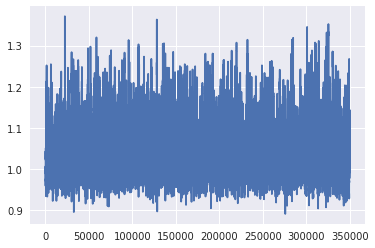

In [7]:
traces_withskew.shape
#for iii in range(26):
#    plt.plot(range(350000), traces_withskew[iii,:])

plt.plot(range(350000), traces_withskew[20,:])

In [ ]:
theta_test = theta_withskew
theta_test[2]=2
theta_test[5]=2
rr_model.test(theta_test, mN1_data, 0, 40, True)

In [ ]:
0.5  6.656626  17.165129  0.017208  5.179458 -0.39041  0.120377  0.980412

In [ ]:
0.5  6.21613  16.712656  0.015974  5.154642 -0.323521  0.140596  1.089871

In [ ]:
failure=np.array([6.21709779, 17.02327498 , 0.09721432 , 4.50759161 , 0.62656029 , 0.36023507,
  0.67244965 , 0.36324047 , 0.95806626  ,0.49547412 , 0.61321619,  0.37430487,
  1.56486318,  0.91031025,  0.24836756,  1.09867159 , 0.36157883 , 0.89449415,
  1.01254314 , 1.41038526 , 0.79970742 , 1.40165622 , 0.73386948 , 1.06883737,
  0.95209786, -0.11787427])

print(failure)
rr_model.test(failure, mN1_data, 0, 40, True)

In [ ]:
testval = -np.inf
testval == -np.inf